In [1]:
import helpFunctions as hf 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imread
import scipy as sp
import os

Load Data

In [2]:
# Folder where your data files are placed
dirIn = "./data/"

matFile = os.path.join(dirIn, 'multispectral_day01.mat')
annFile = os.path.join(dirIn, 'annotation_day01.png')

# Load multispectral image and annotation using your original helpFunctions
multiIm, annotationIm = hf.loadMulti(matFile, annFile)

## The function getPix extracts the multi spectral pixels from the annotation
# Here is an example with meat- and fat annotation
[fatPix, fatR, fatC] = hf.getPix(multiIm, annotationIm[:,:,1]);
[meatPix, meatR, meatC] = hf.getPix(multiIm, annotationIm[:,:,2]);

# load non-annotated pixels to be classified
[bgPix, bgR, bgC] = hf.getPix(multiIm, annotationIm[:,:,0]);

1. Threshold value for a single spectral band

In [3]:
mean_fat = np.mean(fatPix,0)
mean_meat = np.mean(meatPix,0)

var_fat = np.var(fatPix, 0)
var_meat = np.var(meatPix, 0)

t_list = []
errors = []

for i in range(19):
    t = (mean_fat[i] + mean_meat[i])/2
    t_list.append(t)

    n_fat = fatPix.shape[0]
    n_meat = meatPix.shape[0]

    fat_errors = np.sum(fatPix[:, i] < t)
    meat_errors = np.sum(meatPix[:, i] >= t)

    error = (fat_errors + meat_errors) / (n_fat + n_meat)
    errors.append(error)
    #print(f"Spectral Band: {i+1}, t = {t}, error = {error}")

min_error = np.min(errors)
index = errors.index(min_error)
print(f"Spectral Band: {index+1}, t = {t_list[index]: .3}, error = {min_error: .3}")

Spectral Band: 14, t =  69.0, error =  0.00464


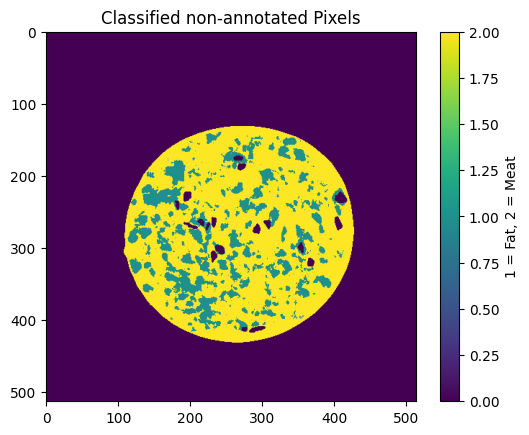

In [4]:
bgPix_14 = bgPix[:, index] # pixels spectral band 14

# 1 = fat, 2 = meat
classified = np.zeros(annotationIm.shape[:2], dtype=np.uint8)

for i in range(bgPix_14.shape[0]):
    r = bgR[i]
    c = bgC[i]

    if bgPix_14[i] > t_list[index]:
        classified[r, c] = 1  # fat
    else:
        classified[r, c] = 2  # meat

plt.imshow(classified)
plt.title("Classified non-annotated Pixels")
plt.colorbar(label="1 = Fat, 2 = Meat")
plt.show()

2. Classification by means of all spectral band

In [26]:
# Covariance
cov_fat = np.cov(fatPix, rowvar=False)
cov_meat = np.cov(meatPix, rowvar=False)

# Number of fat and meat pixels
nf = np.shape(fatPix)[0]
nm = np.shape(meatPix)[0]

# Pooler Covariance - equation 20
pooled_cov = ((nf-1)*cov_fat + (nm-1)*cov_meat)/((nf-1)+(nm-1))

# Discriminant Function - equation 23
p_fat = nf / (nf + nm)
p_meat = nm / (nf + nm)
cov_inv = np.linalg.inv(pooled_cov)

def Discriminant(x,i): 
    if i == 1: # if fat 
        return x @ cov_inv @ mean_fat - 0.5 * mean_fat  @ cov_inv @ mean_fat  + np.log(p_fat)
    if i == 2: # if meat 
        return x @ cov_inv @ mean_meat - 0.5 * mean_meat @ cov_inv @ mean_meat + np.log(p_meat)

def Classify(x):
    S_fat = Discriminant(x, 1)
    S_meat = Discriminant(x, 2)
    if S_fat > S_meat:
        return 1 # fat
    else:
        return 2 # meat
for i in range(bgPix.shape[0]):
    r = bgR[i]
    c = bgC[i]
    classified[r, c] = Classify(bgPix[i])
fat_errors_1 = np.sum(Discriminant(fatPix,1) < Discriminant(fatPix,2))
meat_errors_1 = np.sum(Discriminant(meatPix,2) < Discriminant(meatPix,1))
error_1 = (fat_errors_1+meat_errors_1)/(nf+nm)
print(f"Error: {error_1:.3}")

Error: 0.0101


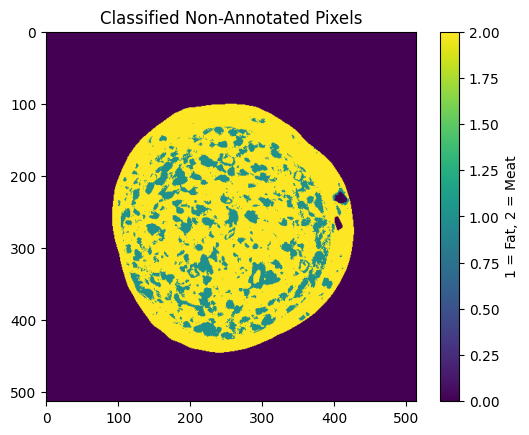

In [27]:
plt.imshow(classified)
plt.title("Classified Non-Annotated Pixels")
plt.colorbar(label="1 = Fat, 2 = Meat")
plt.show()

3. Calculation for all days

loading all data

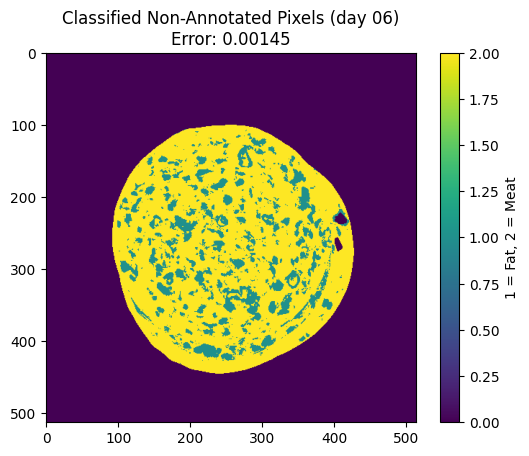

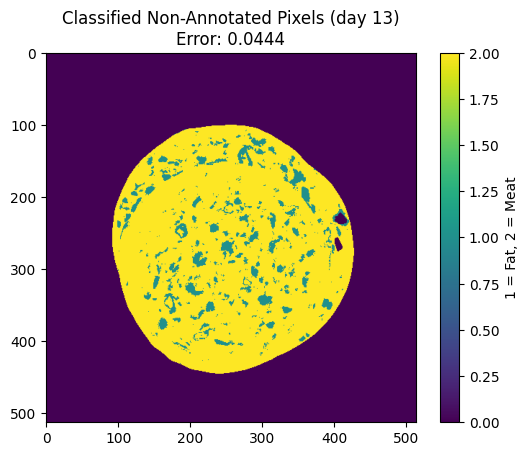

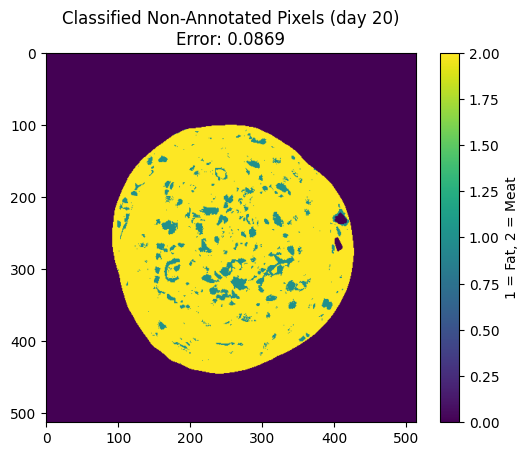

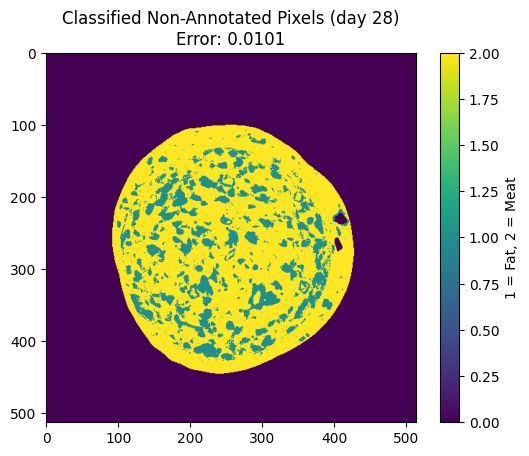

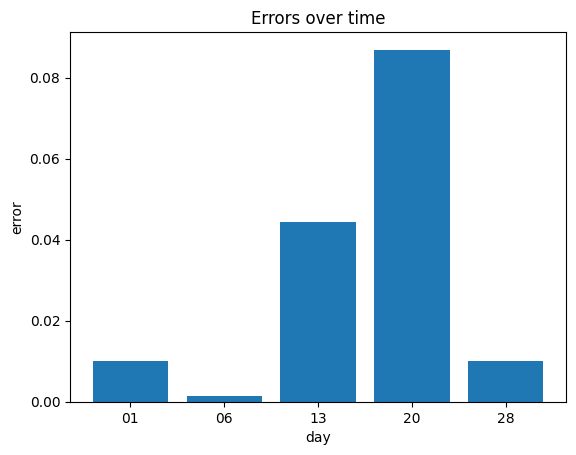

In [ ]:
days = ["01", "06", "13", "20", "28"]
errors = [error_1]

for day in days[1:]:
    # Loading data
    matFile = os.path.join(dirIn, f'multispectral_day{day}.mat')
    annFile = os.path.join(dirIn, f'annotation_day{day}.png')
    multiIm, annotationIm = hf.loadMulti(matFile, annFile)

    [fatPix, fatR, fatC] = hf.getPix(multiIm, annotationIm[:,:,1]);
    [meatPix, meatR, meatC] = hf.getPix(multiIm, annotationIm[:,:,2]);
    [bgPix, bgR, bgC] = hf.getPix(multiIm, annotationIm[:,:,0]);

    # Classify data based on Day 1 model
    for i in range(bgPix.shape[0]):
        r = bgR[i]
        c = bgC[i]
        classified[r, c] = Classify(bgPix[i])

    # Estimate error between classified and annotated data
    fat_errors = np.sum(Discriminant(fatPix,1) < Discriminant(fatPix,2))
    meat_errors = np.sum(Discriminant(meatPix,2) < Discriminant(meatPix,1))
    error = (fat_errors+meat_errors)/(nf+nm)
    errors.append(error)

    # Image
    plt.imshow(classified)
    plt.title(f"Classified Non-Annotated Pixels (day {day})\nError: {error:.3}")
    plt.colorbar(label="1 = Fat, 2 = Meat")
    plt.show()

plt.bar(days, errors)
plt.title("Errors over time")
plt.xlabel("day")
plt.ylabel("error")
plt.show()